In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Data1.csv")

# Tratamiento de datos

Las columnas de atributos "Atributo3" y  "Atributo4" posean un 25% y 30% de sus datos faltantantes, 
ante los datos perdidos se dedice borrar estos campos del conjunto ante que la imputación o reemplazo, 
debido a que no se tiene certeza de la naturaleza de los datos por lo que ejecutar alguan técnica de
imputación estadística no es adecuado, además no se evidencia correlación entre las columnas que permita 
inferir relación entre los valores faltantes.
Eliminar los datos faltantes nos excluye a el 50%  de los datos sin embargo la distribución de los mismos.
de etiquetas.

## Etiquetado

Se uso label encode sobre las columnas de atributos categoricos.


In [3]:
df.dropna(inplace=True)

In [4]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
categorical =  ['Atributo1','Atributo2','Atributo5','Atributo6']

for i in categorical:
    df[i] = label_encoder.fit_transform(df[i])



# 

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Categoria', axis = 1), df['Categoria'], test_size = 0.20, random_state = 12)

# Entrenamos módelo usando GridSearch para el ejuste de paramentros
El primer modelo elegido es Ramdom Forest 

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{ 'n_estimators' : [15,17,18], 'max_depth' : [3, 5, None], 'min_samples_split' : [2, 3, 7] ,
              'bootstrap' :[True, False], 'criterion' : ["gini", "entropy"] }]

rnd_clf = RandomForestClassifier()
grid_search = GridSearchCV (rnd_clf, param_grid, cv = 5 , scoring = 'accuracy', return_train_score = True )
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True, False],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, None],
                          'min_samples_split': [2, 3, 7],
                          'n_estimators': [15, 17, 18]}],
             return_train_score=True, scoring='accuracy')

In [7]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 2,
 'n_estimators': 17}

In [8]:
optimised_rf = grid_search.best_estimator_

In [9]:
y_predRF = optimised_rf.predict(X_test)

In [10]:
Parametros = pd.DataFrame(grid_search.cv_results_['params'])
Score_Train = pd.Series(grid_search.cv_results_['mean_train_score'])
Score_Test = pd.Series(grid_search.cv_results_['mean_test_score'])
grid_score = pd.concat([Parametros,Score_Train.rename('mean_train_score') ,Score_Test.rename('mean_test_score')] ,  axis=1)
grid_score


,bootstrap,criterion,max_depth,min_samples_split,n_estimators,mean_train_score,mean_test_score
0,True,gini,3.0,2,15,0.816581,0.795913
1,True,gini,3.0,2,17,0.831404,0.829225
2,True,gini,3.0,2,18,0.840449,0.833584
3,True,gini,3.0,3,15,0.818750,0.820530
4,True,gini,3.0,3,17,0.814773,0.808915
...,...,...,...,...,...,...,...
103,False,entropy,NaN,3,17,1.000000,0.947909
104,False,entropy,NaN,3,18,1.000000,0.947941
105,False,entropy,NaN,7,15,0.991316,0.934908
106,False,entropy,NaN,7,17,0.993487,0.933448


# Creando métricas

In [11]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred, labels = classes)
    print(cm)

    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[[133   3   0   0]
 [  2  25   0   1]
 [  0   0   4   0]
 [  0   1   0   4]]


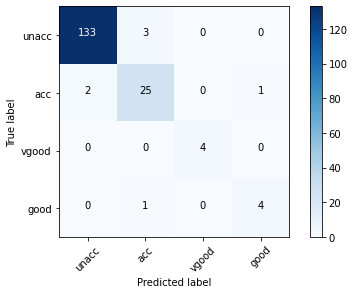

In [12]:
classes = df.Categoria.unique()
plot_confusion_matrix(y_test,y_predRF,classes)


In [13]:
from sklearn.metrics import classification_report
y_true = y_test
target_names = classes
print(classification_report(y_true, y_predRF, target_names=target_names))

              precision    recall  f1-score   support

       unacc       0.86      0.89      0.88        28
         acc       0.80      0.80      0.80         5
       vgood       0.99      0.98      0.98       136
        good       1.00      1.00      1.00         4

    accuracy                           0.96       173
   macro avg       0.91      0.92      0.91       173
weighted avg       0.96      0.96      0.96       173



# Guardando modelo

In [14]:
import joblib
joblib.dump(optimised_rf, 'RF_clf..joblib') 

['RF_clf..joblib']

# Entrenando Segundo modelo SVM

In [44]:
from sklearn.svm import SVC
param_grid = [{ 'C' : [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]}]
clf = SVC(gamma='auto', kernel = 'linear')
grid_search = GridSearchCV (clf, param_grid, cv = 5 , scoring = 'accuracy', return_train_score = True )
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(gamma='auto', kernel='linear'),
             param_grid=[{'C': [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]}],
             return_train_score=True, scoring='accuracy')

In [45]:
Parametros = pd.DataFrame(grid_search.cv_results_['params'])
Score_Train = pd.Series(grid_search.cv_results_['mean_train_score'])
Score_Test = pd.Series(grid_search.cv_results_['mean_test_score'])
grid_score = pd.concat([Parametros,Score_Train.rename('mean_train_score') ,Score_Test.rename('mean_test_score')] ,  axis=1)
grid_score

,C,mean_train_score,mean_test_score
0,0.5,0.804621,0.797425
1,0.6,0.804985,0.800313
2,0.7,0.806070,0.801762
3,0.8,0.807880,0.801762
4,0.9,0.810053,0.801762
5,1.0,0.810054,0.801762
6,1.1,0.812949,0.801762
7,1.2,0.810417,0.801762


In [46]:
grid_search.best_params_

{'C': 0.7}

In [47]:
optimised_svm = grid_search.best_estimator_

In [48]:
y_predSVM = optimised_svm.predict(X_test)

# Obteniendo Métricas

[[135   1   0   0]
 [ 25   3   0   0]
 [  2   2   0   0]
 [  5   0   0   0]]


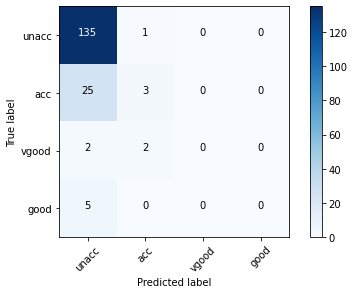

In [49]:
plot_confusion_matrix(y_test,y_predSVM,classes)

In [50]:
print(classification_report(y_true, y_predSVM, target_names=target_names))

              precision    recall  f1-score   support

       unacc       0.50      0.11      0.18        28
         acc       0.00      0.00      0.00         5
       vgood       0.81      0.99      0.89       136
        good       0.00      0.00      0.00         4

    accuracy                           0.80       173
   macro avg       0.33      0.27      0.27       173
weighted avg       0.72      0.80      0.73       173



In [51]:
import joblib
joblib.dump(optimised_svm, 'SVM_clf..joblib') 

['SVM_clf..joblib']